In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from cmdstanpy import CmdStanModel
from multipathogen_sero.config import STAN_DIR
import arviz as az

from multipathogen_sero import (
    simulate_infections,
    simulate_infections_survivor,
    simulation_to_regression_df,
    simulation_to_survey_long,
    survey_long_to_wide,
    independence_test,
    significance
)
from multipathogen_sero.config import EXTERNAL_DATA_DIR

2025-08-13 22:24:42.975 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: /home/ayan/sero/multipathogen-sero


# Load the data

In [7]:
mordor_df_orig = pd.read_csv(EXTERNAL_DATA_DIR / 'mordor-ab-analysis-public.csv')
mordor_df_orig['testdate'] = pd.to_datetime(mordor_df_orig['testdate'])
mordor_df_orig.sort_values(by=['clusterid_public', 'childid_public', 'testdate', 'pathogen', 'antigen'], inplace=True)
start_date = mordor_df_orig['testdate'].min()

In [8]:
pathogen_antigen_df = (
    mordor_df_orig[['pathogen', 'antigen','serocut','serocut_desc']]
    .drop_duplicates()
    .sort_values(by=['pathogen', 'antigen'])
    .reset_index(drop=True)
    .assign(logserocut=lambda df: np.log10(df['serocut']))
)
pathogen_antigen_df['antigen_int'] = pathogen_antigen_df.index + 1
antigen_list = list(pathogen_antigen_df['antigen'])

In [9]:
child_visit_df = mordor_df_orig[['clusterid_public', 'phase', 'arm', 'childid_public', 'agem',
       'agem_start', 'agem_start_under6', 'sex', 'testdate', 'wet_start',
       'wet_end', 'season', 'malaria_thicksmear', 'malaria_density',
       'malaria_gameto', 'dbsid', 'type', 'well']].drop_duplicates()

# Calculate implied_birth_month and agem_is_rounded
child_visit_df['treated'] = child_visit_df['arm']=='azithro'
child_visit_df['test_month'] = 12*(child_visit_df['testdate'].dt.year - start_date.year) + child_visit_df['testdate'].dt.month - start_date.month
child_visit_df = child_visit_df.assign(
    implied_birth_month=lambda df: df['test_month'] - df['agem'],
    agem_is_rounded=lambda df: df['agem'] % 6 == 0
)
child_visit_df['child_int'] = child_visit_df['childid_public'].astype('category').cat.codes + 1 


def compute_birth_month(group):
    if not group['agem_is_rounded'].all():
        val = group.loc[~group['agem_is_rounded'], 'implied_birth_month'].mean()
    else:
        val = group['implied_birth_month'].mean()
    val = min(min(group['test_month']-1), val) #ensure birth month is earlier than test month
    return pd.Series({'averaged_birth_month': val})

birth_month_df = (
    child_visit_df
    .groupby('child_int')
    .apply(compute_birth_month, include_groups=False)
    .reset_index()
)

# Merge averaged_birth_month back into child_visit_df and calculate agem_est
child_visit_df = (
    child_visit_df
    .merge(birth_month_df, on='child_int', how='left')
    .assign(agem_est=lambda df: df['test_month'] - df['averaged_birth_month'])
    .sort_values(by=['clusterid_public', 'child_int', 'test_month'])
)

mordor_df = (
    mordor_df_orig
    .merge(child_visit_df[['childid_public', 'phase', 'agem_est', 'child_int','treated','test_month']], on=['childid_public', 'phase'], how='left')
)
mordor_df

,clusterid_public,phase,arm,childid_public,agem,agem_start,agem_start_under6,sex,testdate,wet_start,...,antigenf,mfi,logmfi,serocut,serocut_desc,seropos,agem_est,child_int,treated,test_month
0,community-1,6,placebo,child-10069,17,12.594525,No,male,2015-09-15,2015-05-15,...,Campylobacter p18,26008,4.415107,843.0,presumed unexp,1.0,15.0,16,False,6
1,community-1,6,placebo,child-10069,17,12.594525,No,male,2015-09-15,2015-05-15,...,Campylobacter p39,29955,4.476469,338.0,presumed unexp,1.0,15.0,16,False,6
2,community-1,6,placebo,child-10069,17,12.594525,No,male,2015-09-15,2015-05-15,...,Cholera CTB,26237,4.418914,438.0,presumed unexp,1.0,15.0,16,False,6
3,community-1,6,placebo,child-10069,17,12.594525,No,male,2015-09-15,2015-05-15,...,Cryptosporidium Cp17,30111,4.478725,290.0,external,1.0,15.0,16,False,6
4,community-1,6,placebo,child-10069,17,12.594525,No,male,2015-09-15,2015-05-15,...,Cryptosporidium Cp23,32216,4.508072,945.0,external,1.0,15.0,16,False,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135403,community-9,12,azithro,child-9870,56,44.427410,No,male,2016-06-15,2016-04-15,...,Salmonella group D LPS,174,2.240549,10.0,presumed unexp,1.0,56.0,3760,True,15
135404,community-9,12,azithro,child-9870,56,44.427410,No,male,2016-06-15,2016-04-15,...,Streptococcus group A SPEB,14092,4.148973,884.0,presumed unexp,1.0,56.0,3760,True,15
135405,community-9,12,azithro,child-9870,56,44.427410,No,male,2016-06-15,2016-04-15,...,Strongyloides NIE,-59,0.000000,3523.0,external,0.0,56.0,3760,True,15
135406,community-9,12,azithro,child-9870,56,44.427410,No,male,2016-06-15,2016-04-15,...,Trachoma CT694,16,1.204120,457.0,external,0.0,56.0,3760,True,15


In [10]:
sero_df = mordor_df[['child_int', 'treated', 'test_month', 'agem_est', 'phase', 'pathogen', 'antigen',
       'mfi', 'logmfi', 'seropos']]
seropositivity_long = sero_df[['child_int', 'treated', 'test_month', 'agem_est', 'phase', 'antigen', 'seropos']]
seropositivity_wide = seropositivity_long.pivot_table(
    index=['child_int', 'treated', 'test_month', 'agem_est', 'phase'],
    columns='antigen',
    values='seropos',
    aggfunc='first'
).reset_index()

log_mfi_long = sero_df[['child_int', 'treated', 'test_month', 'agem_est', 'phase', 'antigen', 'logmfi']]
log_mfi_wide = log_mfi_long.pivot_table(
    index=['child_int', 'treated', 'test_month', 'agem_est', 'phase'],
    columns='antigen',
    values='logmfi',
    aggfunc='first'
).reset_index()

In [11]:
def reorder_columns(df, antigen_list):
    """Reorder columns of the DataFrame to have specified antigens at the end."""
    return df[
        [col for col in df.columns if col not in antigen_list] +
        [col for col in antigen_list if col in df.columns]
    ]
log_mfi_wide = reorder_columns(log_mfi_wide, antigen_list)
seropositivity_wide = reorder_columns(seropositivity_wide, antigen_list)

# Pairwise correlation
## Unstratified population
Taking most recent sample from each child
First the log mfi and after the seropositivity

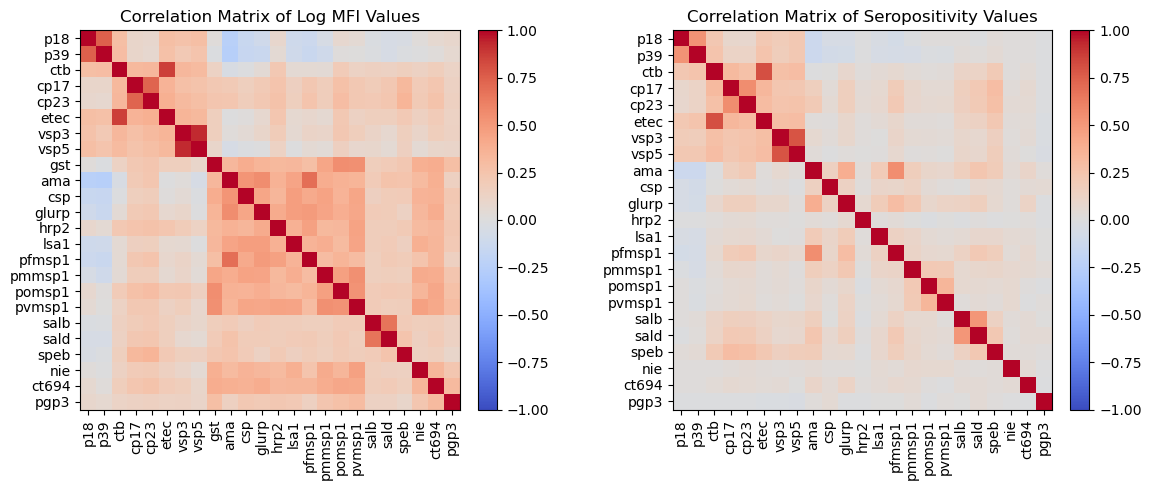

In [12]:
log_mfi_wide_most_recent = (
    log_mfi_wide
    .sort_values(['child_int', 'test_month'])
    .groupby('child_int')
    .last()
    .reset_index()
)
seropositivity_wide_most_recent = (
    seropositivity_wide
    .sort_values(['child_int', 'test_month'])
    .groupby('child_int')
    .last()
    .reset_index()
)
correlation_mat = log_mfi_wide_most_recent[[col for col in antigen_list if col in log_mfi_wide_most_recent.columns]].corr()
correlation_mat_sero = seropositivity_wide_most_recent[[col for col in antigen_list if col in seropositivity_wide_most_recent.columns]].corr()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First heatmap: Log MFI Values
im1 = axes[0].imshow(correlation_mat, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_xticks(np.arange(len(correlation_mat.columns)))
axes[0].set_xticklabels(correlation_mat.columns, rotation=90)
axes[0].set_yticks(np.arange(len(correlation_mat.index)))
axes[0].set_yticklabels(correlation_mat.index)
axes[0].set_title('Correlation Matrix of Log MFI Values')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Second heatmap: Seropositivity Values
im2 = axes[1].imshow(correlation_mat_sero, cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_xticks(np.arange(len(correlation_mat_sero.columns)))
axes[1].set_xticklabels(correlation_mat_sero.columns, rotation=90)
axes[1].set_yticks(np.arange(len(correlation_mat_sero.index)))
axes[1].set_yticklabels(correlation_mat_sero.index)
axes[1].set_title('Correlation Matrix of Seropositivity Values')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Stratified by age
In bins of width six months

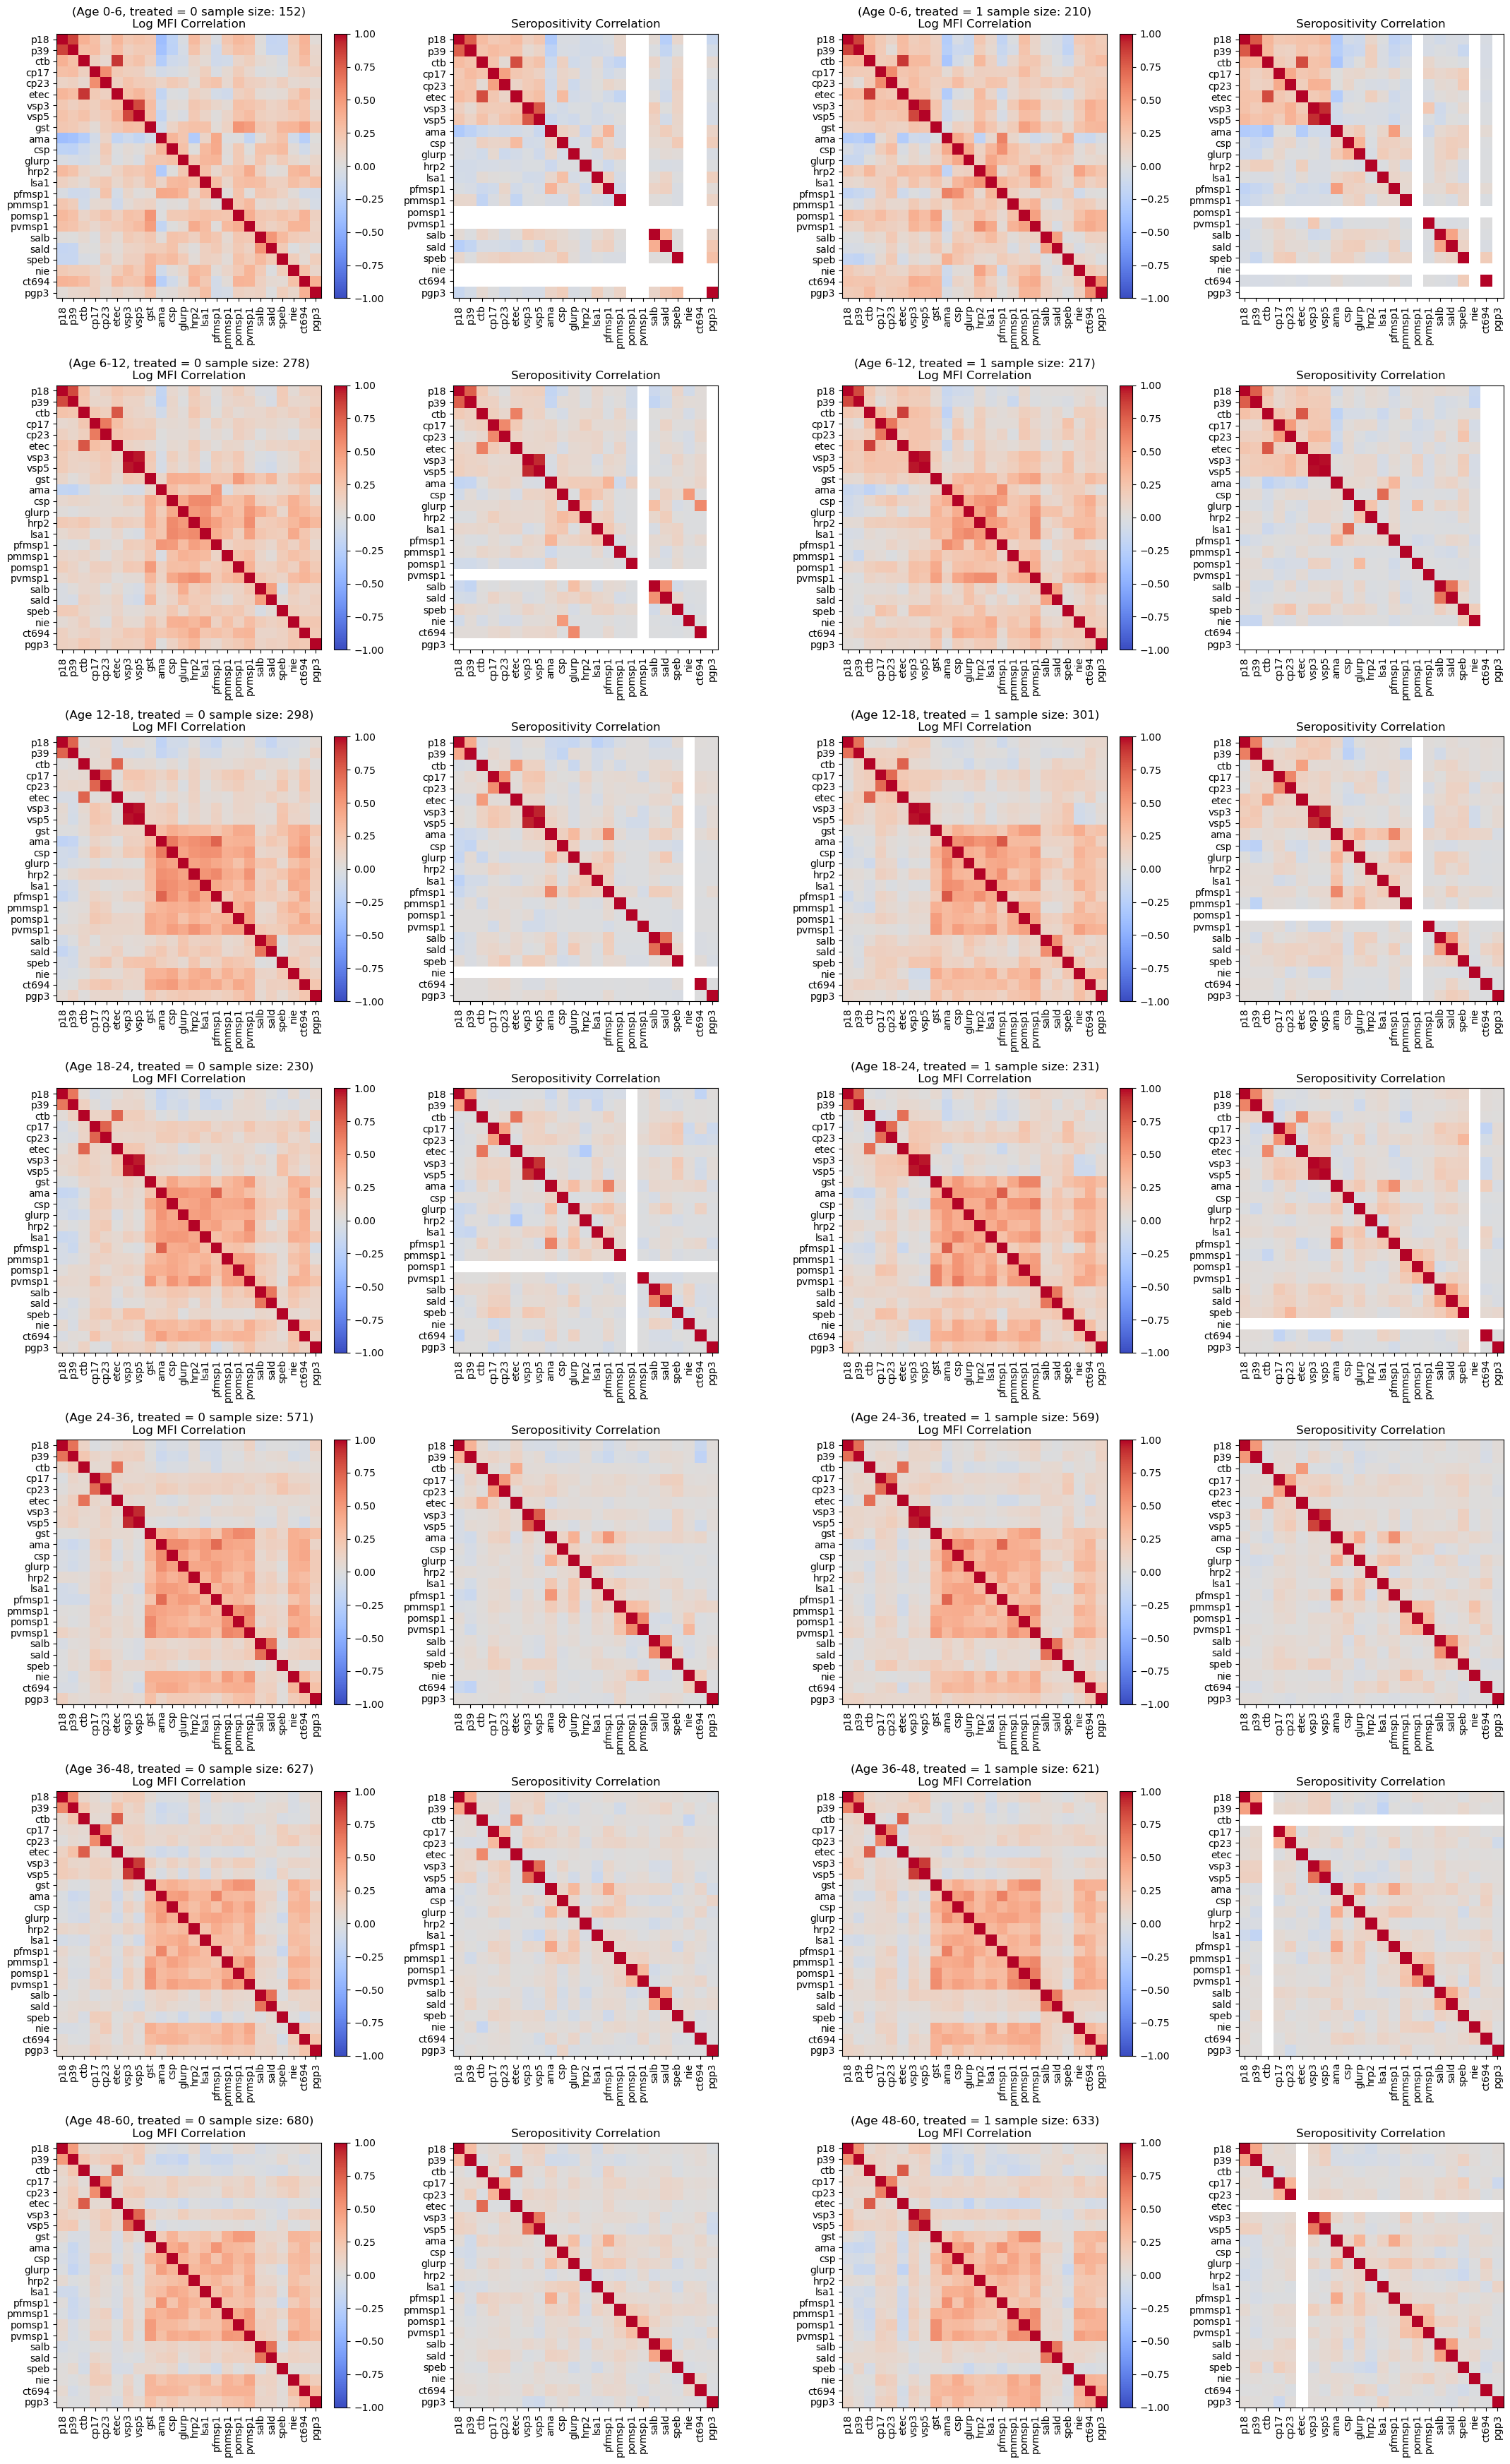

In [13]:
bin_edges = [0,6,12,18,24,36,48,60]
n_bins = len(bin_edges)-1
fig, axes = plt.subplots(n_bins, 4, figsize=(22, 5 * n_bins))

for i in range(n_bins):
    left_edge = bin_edges[i]
    right_edge = bin_edges[i+1]
    for treated in [0,1]:
        log_mfi_wide_age_arm_bin = log_mfi_wide.query(
            f'agem_est >= {left_edge} and agem_est < {right_edge} and treated == {treated}'
        )
        seropositivity_wide_age_arm_bin = seropositivity_wide.query(
            f'agem_est >= {left_edge} and agem_est < {right_edge} and treated == {treated}'
        )
    
        # Compute correlation matrices
        corr_mfi = log_mfi_wide_age_arm_bin[[col for col in log_mfi_wide_age_arm_bin.columns if col in antigen_list]].corr()
        corr_sero = seropositivity_wide_age_arm_bin[[col for col in seropositivity_wide_age_arm_bin.columns if col in antigen_list]].corr()

        # Plot Log MFI correlation
        im1 = axes[i, 0+treated*2].imshow(corr_mfi, cmap='coolwarm', vmin=-1, vmax=1)
        axes[i, 0+treated*2].set_xticks(np.arange(len(corr_mfi.columns)))
        axes[i, 0+treated*2].set_xticklabels(corr_mfi.columns, rotation=90)
        axes[i, 0+treated*2].set_yticks(np.arange(len(corr_mfi.index)))
        axes[i, 0+treated*2].set_yticklabels(corr_mfi.index)
        axes[i, 0+treated*2].set_title(f'(Age {left_edge}-{right_edge}, treated = {treated} sample size: {len(log_mfi_wide_age_arm_bin)})\n Log MFI Correlation ')
        fig.colorbar(im1, ax=axes[i, 0+treated*2], fraction=0.046, pad=0.04)

        # Plot Seropositivity correlation
        im2 = axes[i, 1+treated*2].imshow(corr_sero, cmap='coolwarm', vmin=-1, vmax=1)
        axes[i, 1+treated*2].set_xticks(np.arange(len(corr_sero.columns)))
        axes[i, 1+treated*2].set_xticklabels(corr_sero.columns, rotation=90)
        axes[i, 1+treated*2].set_yticks(np.arange(len(corr_sero.index)))
        axes[i, 1+treated*2].set_yticklabels(corr_sero.index)
        axes[i, 1+treated*2].set_title(f'Seropositivity Correlation')

plt.tight_layout()
plt.show()

# Bayesian modelling

In [14]:
SUBSAMPLE=True

n_people = mordor_df['child_int'].nunique()
n_antigens = pathogen_antigen_df['antigen_int'].nunique()
survey_times = {row.child_int: [row.averaged_birth_month] for row in child_visit_df[['child_int','averaged_birth_month']].drop_duplicates().itertuples()}
for row in child_visit_df.itertuples():
    survey_times[row.child_int].append(float(row.test_month))
infection_intervals = seropositivity_long.copy()
infection_intervals = infection_intervals.merge(
    pathogen_antigen_df[['antigen', 'antigen_int']],
    on='antigen',
    how='left'
)

if SUBSAMPLE:
    n_people = 200
    n_antigens = 2
    survey_times = {k: v for k, v in survey_times.items() if k <= n_people}
    infection_intervals.query('child_int <= @n_people', inplace=True)
    infection_intervals = infection_intervals.query('antigen_int <= @n_antigens')

In [27]:
infection_intervals['prev_seropos'] = (
    seropositivity_long
    .groupby(['child_int', 'antigen'])['seropos']
    .shift(1)
    .fillna(0.0)
    # assumes seronegative at birth
)
infection_intervals['prev_test_month'] = (
    seropositivity_long
    .groupby(['child_int', 'antigen'])['test_month']
    .shift(1)
    .astype(float)
    .fillna(seropositivity_long['test_month'] - seropositivity_long['agem_est'])
    # assumes seronegative at birth
)
infection_intervals.query(
    'prev_seropos == 0 and seropos == 1',
    inplace=True
)

infection_intervals = infection_intervals.groupby(['child_int', 'antigen'], as_index=False).first()


# lookup
gets_infected = np.zeros((n_people, n_antigens), dtype=bool)
lookup_indices = np.zeros((n_people, n_antigens), dtype=int)
for counter, row in enumerate(infection_intervals.itertuples()):
    gets_infected[row.child_int - 1, row.antigen_int - 1] = True
    lookup_indices[row.child_int - 1, row.antigen_int - 1] = counter+1 #1-indexed
num_infections = gets_infected.sum()

# noninfections
num_noninfections = n_people * n_antigens - num_infections
indices = np.argwhere(gets_infected == 0)
lookup_indices[gets_infected == 0] = np.arange(1, num_noninfections + 1) #1-indexed
noninfection_person_ids = indices[:, 0] + 1  # Convert to 1-based indexing
noninfection_pathogen_ids = indices[:, 1] + 1  # Convert to 1-based indexing
censoring_times = np.array([survey_times[i][-1] for i in noninfection_person_ids])
lower_bound_times = infection_intervals['prev_test_month'].values
upper_bound_times = infection_intervals['test_month'].values
infection_person_ids = infection_intervals['child_int'].values
infection_antigen_ids = infection_intervals['antigen_int'].values

In [37]:

model = CmdStanModel(
    stan_file= STAN_DIR / "multiplex_serology.stan"
)

22:41:55 - cmdstanpy - INFO - compiling stan file /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/multiplex_serology.stan to exe file /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/multiplex_serology
22:42:11 - cmdstanpy - INFO - compiled model executable: /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/multiplex_serology


In [ ]:
"""
data {
    int<lower=1> N;                         // Number of individuals
    array[N] real birth_times;               // Birth time for each individual
    int<lower=1> K;                         // Number of pathogens
    array[N,K] int<lower=0, upper=1> gets_infected; // 0 = always negative, 1 = seroconverter
    int<lower=0> num_infections; // Number of infection times (seroconversions)
    int<lower=0> num_noninfections; // Number of uninfected individuals (seronegative)
    array[N,K] int<lower=1, upper=N*K> lookup_indices; // Index to look up individual, pathogen infection times in their respective (1-indexed) arrays
    array[num_infections] real lower_bound_times; // Lower bound of seroconversion time
    array[num_infections] real upper_bound_times; // Upper bound of seroconversion time
    array[num_infections] int<lower=1, upper=N> infection_person_ids; // Individual ID for each seroconversion (should be 1-indexed)
    array[num_infections] int<lower=1, upper=K> infection_pathogen_ids; // Pathogen ID for each seroconversion (should be 1-indexed)
    array[num_noninfections] real censoring_times; // Lower bound of seroconversion time
    array[num_noninfections] int<lower=1, upper=N> noninfection_person_ids; // Individual ID for each seronegative individual (should be 1-indexed)
    array[num_noninfections] int<lower=1, upper=K> noninfection_pathogen_ids; // Pathogen ID for each seronegative individual (should be 1-indexed)
    real <lower=0> time_to_immunity; // timescale for immunity to kick in
                                     // not scientific, just to make the likelihood continuous wrt latent infection times 
    real <lower=0> beta_scale; // scale for Laplace prior on log hazard ratios
}
"""
# TODO: write tests
stan_data = {
    "N": n_people,
    "K": n_antigens,
    "birth_times": [survey_times[i][0] for i in range(1, n_people + 1)],
    "gets_infected": gets_infected,
    "num_infections": num_infections,
    "num_noninfections": num_noninfections,
    "lookup_indices": lookup_indices,
    "lower_bound_times": lower_bound_times,
    "upper_bound_times": upper_bound_times,
    "infection_person_ids": infection_person_ids,
    "infection_pathogen_ids": infection_antigen_ids,
    "censoring_times": censoring_times,
    "noninfection_person_ids": noninfection_person_ids,
    "noninfection_pathogen_ids": noninfection_pathogen_ids,
    "time_to_immunity": 0.05,  # timescale for immunity to kick in
    "beta_scale": 1.0,  # scale for Laplace prior on log hazard ratios
}


# print(birth_times[0])
print(gets_infected[0])
print(lookup_indices[0])
# print(last_survey_times[lookup_indices[0][gets_infected[0]]-1])
# print(next_survey_times[lookup_indices[0][gets_infected[0]]-1])
# print(infection_person_ids[lookup_indices[0][gets_infected[0]]-1])
# print(infection_pathogen_ids[lookup_indices[0][gets_infected[0]]-1])
print(censoring_times[lookup_indices[0][~gets_infected[0]]-1])
print(noninfection_person_ids[lookup_indices[0][~gets_infected[0]]-1])
print(noninfection_pathogen_ids[lookup_indices[0][~gets_infected[0]]-1])

[ True  True]
[1 2]
[]
[]
[]


In [36]:

#save to json
import json
def to_json_friendly(x):
    if isinstance(x, np.ndarray):
        return x.tolist()
    elif isinstance(x, (np.integer, np.floating)):
        return x.item()
    elif isinstance(x, (list, tuple)):
        return [to_json_friendly(i) for i in x]
    elif isinstance(x, dict):
        return {k: to_json_friendly(v) for k, v in x.items()}
    elif isinstance(x, bool):
        return int(x)
    else:
        return x
stan_data_json = {k: to_json_friendly(v) for k, v in stan_data.items()}

for key in stan_data_json:
    print(f"{key}: {type(stan_data_json[key])}")
    if isinstance(stan_data_json[key], (list, np.ndarray)):
        print(f"  Length: {len(stan_data_json[key])}; first entry is of type {type(stan_data_json[key][0])}")
        if isinstance(stan_data_json[key][0], (list, np.ndarray)):
            print(f"  Length of first entry: {len(stan_data_json[key][0])}; first entry of first entry is of type {type(stan_data_json[key][0][0])}")
with open(f"{STAN_DIR}/mordor_stan_data.json", 'w') as f:
    json.dump(stan_data_json, f, indent=4)

N: <class 'int'>
K: <class 'int'>
birth_times: <class 'list'>
  Length: 200; first entry is of type <class 'float'>
gets_infected: <class 'list'>
  Length: 200; first entry is of type <class 'list'>
  Length of first entry: 2; first entry of first entry is of type <class 'int'>
num_infections: <class 'int'>
num_noninfections: <class 'int'>
lookup_indices: <class 'list'>
  Length: 200; first entry is of type <class 'list'>
  Length of first entry: 2; first entry of first entry is of type <class 'int'>
lower_bound_times: <class 'list'>
  Length: 349; first entry is of type <class 'float'>
upper_bound_times: <class 'list'>
  Length: 349; first entry is of type <class 'int'>
infection_person_ids: <class 'list'>
  Length: 349; first entry is of type <class 'int'>
infection_pathogen_ids: <class 'list'>
  Length: 349; first entry is of type <class 'int'>
censoring_times: <class 'list'>
  Length: 51; first entry is of type <class 'float'>
noninfection_person_ids: <class 'list'>
  Length: 51; f

In [ ]:
chains = 4
iter_sampling = 500
iter_warmup = 100
parallel_chains = 4
seed = 123
max_treedepth = 15
fit = model.sample(
    data=stan_data,
    chains=chains,
    iter_sampling=iter_sampling,
    iter_warmup=iter_warmup,
    parallel_chains=parallel_chains,
    seed=seed,
    max_treedepth=max_treedepth,
    show_progress=True,
    show_console=False
)

20:30:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:52:49 - cmdstanpy - INFO - CmdStan done processing.


Checking sampler transitions treedepth.
2000 of 500 (400.00%) transitions hit the maximum treedepth limit of 13, or 2^13 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.22, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  baseline_hazards[1], baseline_hazards[2], baseline_hazards[3], betas[1], betas[2], betas[3], betas[4], betas[5], betas[6], infection_times[3], infection_times[4], infection_times[5], infection_times[6], infection_times[8], infection_times[9], in

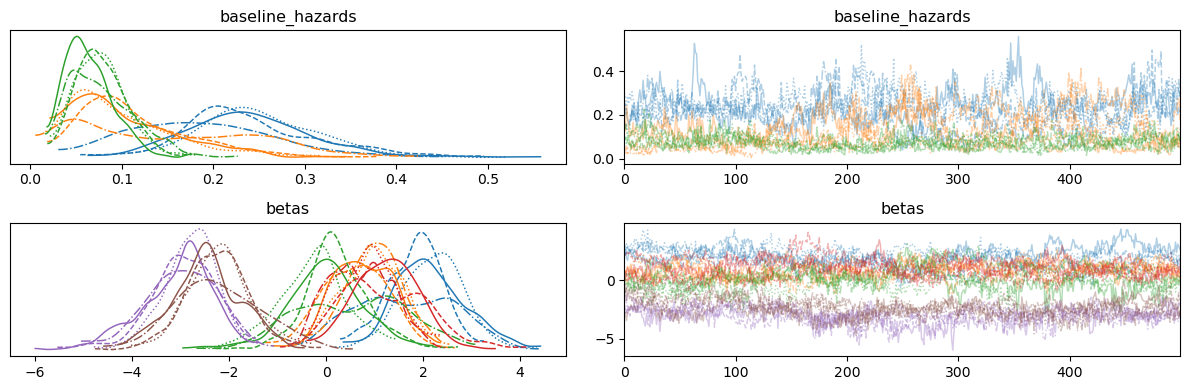

In [166]:
# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazards", "betas"])
plt.tight_layout()
plt.show()